# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__
__Тема письма: `[ML][HW01] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from heapq import merge

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщен
ий.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быь упорядочен случайно.

In [2]:
def rak(label):
    if label == 'M':
        return 1
    else:
        return 0


def normalize(array):
    mins = np.array([min(array[:, k]) for k in range(len(array[0]))])
    maxs = np.array([max(array[:, k]) for k in range(len(array[0]))])
    array = np.array([(vector - mins) / (maxs - mins) for vector in array])
    return array


def read_cancer_dataset(path_to_csv):
    dataframe = pandas.read_csv(path_to_csv, header=1)
    data = dataframe.values.tolist()
    np.random.shuffle(data)
    valuesArray = np.array(data)[:, 1:]
    labelsVector = np.array(data)[:, 0]
    labelsVector = np.array(list(map(rak, labelsVector)))
    valuesArray = np.array(list(map(lambda v: list(map(float, v)), valuesArray)))
    valuesArray = normalize(valuesArray)
    return valuesArray, labelsVector


def read_spam_dataset(path_to_csv):
    dataframe = pandas.read_csv(path_to_csv, header=1)
    data = dataframe.values.tolist()
    np.random.shuffle(data)
    valuesArray = np.array(data)[:, :-1]
    valuesArray = normalize(valuesArray)
    labelsVector = np.array(data)[:, -1]
    return valuesArray, labelsVector


### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

In [3]:
def train_test_split(X, y, ratio):
    n = int(ratio * len(X))
    return X[:n], y[:n], X[n:], y[n:]


### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса. 

__Precision__ отражает то, насколько редко мы ошибаемся, когда говорим, что объект пренадлежит к классу. 

__Recall__ же отражает то, насколько редко классификатор неправильно классифицирует объекты данного класса.

__Accuracy__ отражает то, какую часть выборки классификатор отнес к правильному классу.

In [4]:
def prec(y_pred, y_true):
    precision_num = (y_pred * y_true).tolist().count(1)
    precision_den = y_pred.tolist().count(1)
    return precision_num / precision_den

def rec(y_pred, y_true):
    recall_num = (y_pred * y_true).tolist().count(1)
    recall_den = y_true.tolist().count(1)
    return recall_num / recall_den


def acc(y_pred, y_true):
    accuracy_num = (y_pred + y_true).tolist().count(0) + (y_pred + y_true).tolist().count(2)
    accuracy_den = len(y_pred)
    return accuracy_num / accuracy_den


def rev(y):
    return np.array(list(map(lambda x: 1 - x, y)))


def get_precision_recall_accuracy(y_pred, y_true):
    return [prec(rev(y_pred), rev(y_true)), prec(y_pred, y_true)], [rec(rev(y_pred), rev(y_true)),
                                                                    rec(y_pred, y_true)], [
               acc(rev(y_pred), rev(y_true)), acc(y_pred, y_true)]


Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [5]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    precisions = [[] for _ in range(2)]
    recalls = [[] for _ in range(2)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(2):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [6]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [7]:
def split(X, indexes, dim):
    Y = np.array(sorted(list(zip(X, indexes)), key=lambda x: x[0][dim]))
    middle = int(len(Y) / 2)
    leftY = Y[:middle]
    rightY = Y[middle:]
    mediane = Y[middle][0][dim]
    return np.array(list(map(lambda x: x[0], leftY))), np.array(list(map(lambda x: x[1], leftY))), np.array(
        list(map(lambda x: x[0], rightY))), np.array(list(map(lambda x: x[1], rightY))), mediane


def neighbots(X, indexes, point, k):
    Y = list(map(lambda x: (np.linalg.norm(x[0] - point), x[1]), list(zip(X, indexes))))
    return sorted(Y, key=lambda x: x[0])[:k]


class KDTree:
    def __init__(self, X, leaf_size=40, indexes=np.array([]), dim=0):
        if len(X) <= leaf_size:
            self.indexes = indexes
            if len(indexes) == 0:
                self.indexes = np.array(list(range(len(X))))
            self.leaf = True
            self.X = X
        else:
            if len(indexes) == 0:
                indexes = np.array(list(range(len(X))))
            self.leaf = False
            self.dim = dim
            leftX, leftInd, rightX, rightInd, mediane = split(X, indexes, self.dim)
            self.mediane = mediane
            self.left = KDTree(leftX, leaf_size, leftInd, (dim + 1) % len(X[0]))
            self.right = KDTree(rightX, leaf_size, rightInd, (dim + 1) % len(X[0]))

    def query4one(self, point, k=1):
        if self.leaf:
            return neighbots(self.X, self.indexes, point, k)
        else:
            dist_to_border = abs(point[self.dim] - self.mediane)
            if point[self.dim] <= self.mediane:
                answer = self.left.query4one(point, k)
                if len(answer) < k or answer[-1][0] > dist_to_border:
                    answer = list(merge(answer, self.right.query4one(point, k), key=lambda x: x[0]))[:k]
            if point[self.dim] > self.mediane:
                answer = self.right.query4one(point, k)
                if len(answer) < k or answer[-1][0] > dist_to_border:
                    answer = list(merge(answer, self.left.query4one(point, k), key=lambda x: x[0]))[:k]
            return answer

    def query(self, X, k=1, return_distance=True):
        if return_distance:
            return list(map(lambda x: self.query4one(np.array(x), k), X))
        else:
            return list(map(lambda x: list(map(lambda y: y[1], self.query4one(np.array(x), k))), X))


Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [8]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4, return_distance=False)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток "обучать" классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [9]:
class KNearest:
    def __init__(self, n_neighbors=5, leaf_size=30):
        self.tree = None
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.answers = None

    def fit(self, X, y):
        self.tree = KDTree(X, self.leaf_size)
        self.answers = y

    def predict_proba(self, X):
        list1 = list(
            map(lambda x: list(map(lambda z: self.answers[z], x)), self.tree.query(X, self.n_neighbors, False)))
        return list(map(lambda x: np.array([x.count(0), x.count(1)])/(x.count(0)+x.count(1)) , list1))

    def predict(self, X):
        return np.array(list(map(lambda x: np.argmax(x), self.predict_proba(X))))



Наконец, протестируем наш классификатор на различных наборах данных

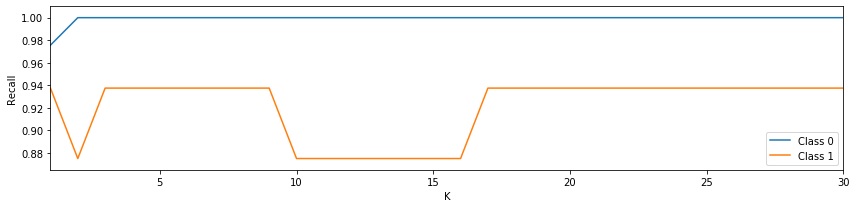

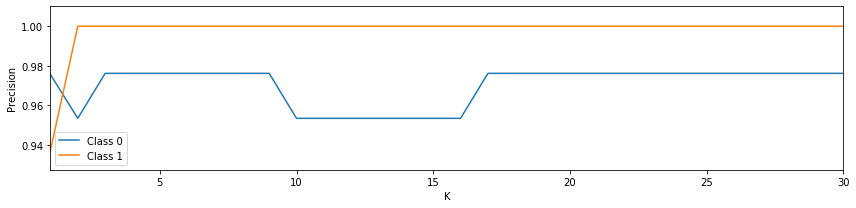

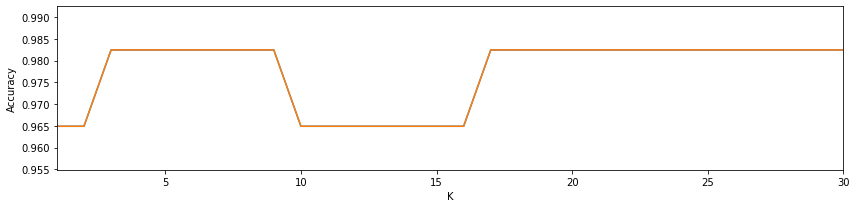

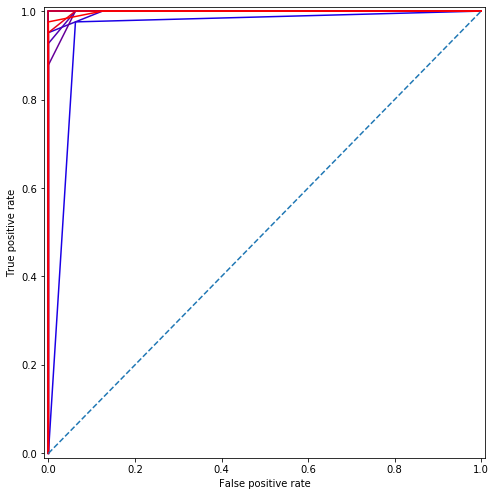

In [10]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

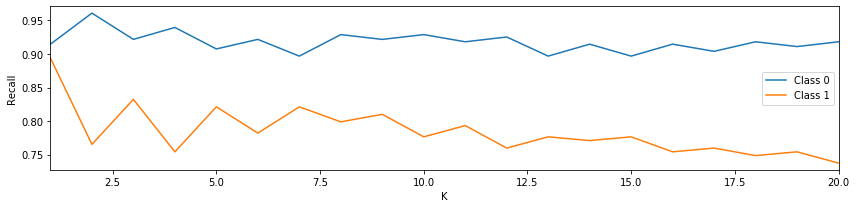

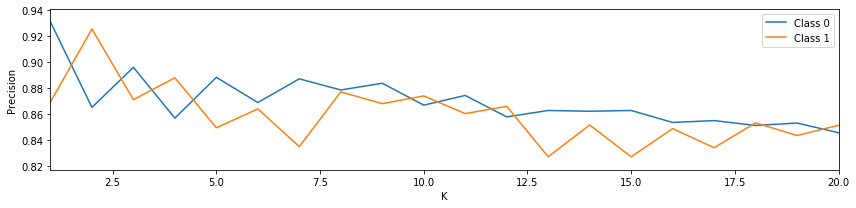

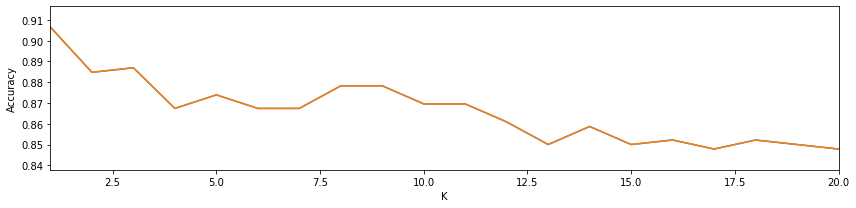

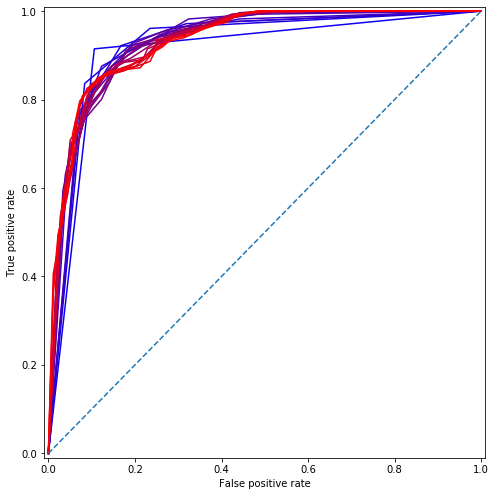

In [11]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)